# <font style="color:blue">Mean Average Precision (mAP)</font>

In this unit we will discuss and implement a variant of a very common object
detection metric - Average Precision (mAP).

The variant of Average Precision (AP) metric we're going to implement was
introduced in the [PASCAL
VOC](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) challenge. During the
years of the challenge, it was changed several times, so let's discuss the
common pipeline and its specific parts.

We will implement the AP calculation with some limitations. They are not
applicable to the real cases, but your final code may be easily transofrmed
to a general case.
1. All the ground truth objects and detection objects are from the same image
   (we consider the case of one image only).
2. All the ground truth objects and detection objects belong to the same
   class (we consider the case of 1 class only).

Let's briefly recall the essential concepts:
* **True Positives (TP)** - correctly detected objects.
* **False Positives (FP)** - incorrectly detected objects.
* **False Negative (FN)** - GT boxes that do not have a
  corresponding detection with high enough IoU.
* **Precision** is the ratio of true positives in the obtained results. In
  other words, it is the percentage of correct predictions among all
  predictions:
  $ \text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} =
  \frac{\text{TP}}{D},$ where $D$ is a total number of detections.
* **Recall** - the amount of true positives we found among all the GT boxes in the data.
  $\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} =
  \frac{\text{TP}}{G},$ where $G$ is a total number of ground truth objects.
* **Intersection over Union** is a way to measure the level of overlap
  between bounding boxes, for example, between ground truth and predicted
  detection boxes: $\text{IoU} = \frac{\text{intersection_area}}{\text{union_area}}$

Computation pipeline in the object detection context is the following:
1. for each confidence threshold among selected confidence levels:
     1. select detections with confidences higher than the confidence threshold
     2. find the correspondence between the detections and ground truths:
         1. sort the detections according to their scores in descending order
         2. compute the Intersection over Union (IoU) of detection boxes with GT
         bounding boxes
         3. for each detection, find the ground truth with the highest IoU higher than
         IoU threshold
         4. for each ground truth, find all the detections with IoUs higher than IoU
         threshold.
     3. define and count the true positives, false positives, false negatives.
         1. all the detections associated with ground truths that have only one match
         are considered true positives
         2. in case if the ground truth object has more than one associated detection:
             - the associated detection with the highest score is considered to be the true
             positive
             - other detections are considered to be false positives
         3. all detections that have no associated ground truth objects (due to too
         low IoUs) are considered false positives
     4. calculate the recall and the precision with the given numbers of TP, FP and ground
     truth objects
2. after the step 1, we have precision at some points - interpolate the
precision at all other points
3. calculate the Average Precision (AP) as the area under the interpolated curve

When we computed pairs of recall and precision at confidence thresholds, we
can plot a precision-recall curve: x-axis is recall, and y-axis - precision.

In practice, researchers typically use an interpolated version of the
recall-precision curve. In this case, we do not estimate the recall-precision
pairs for every possible confidence threshold. Instead, we select some
points, measure the recall and precision in them, and interpolate all the
values in between. To compute the interpolated precision, we use the maximum
value for the specified recall level:
$p_{\text{interp}}(r) = \underset{r':r'\geq r}\max{p(r')}$

When all the ingrediends we described are defined, we can evaluate the mean
average precision value. According to [The PASCAL Visual Object Classes (VOC)
Challenge](http://homepages.inf.ed.ac.uk/ckiw/postscript/ijcv_voc09.pdf), the
mean precision at a set of eleven equal recalls defines the AP:

$$
\text{AP} = \frac{1}{11}_{r\in{\{0, 0.1,...,1\}}}\sum{p_{\text{interp}}(r)}
$$

Thus, AP summarizes the interpolated precisions at `11` recall areas from  0 to 1: `0.0, 0.1, ..., 1`

Let's Implement Average Precision (as an approximation of the
precision-recall curve by 11 points) based on the [The PASCAL Visual Object
Classes (VOC)
Challenge](http://homepages.inf.ed.ac.uk/ckiw/postscript/ijcv_voc09.pdf)
article.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## <font style="color:Blue">1. Utils Methods</font>

### <font style="color:green">Intersection Over Union (IoU)</font>

Find IoU for a predicted bounding box with all ground truth boxes.

In [2]:
def get_iou(predicted_dbox, ground_truth_dboxes):
    """
        Calculates IoU (Jaccard index) of two detection boxes:
            predicted_dbox ∩ ground_truth_dbox / (area(predicted_dbox) +
            area(ground_truth_dbox) - predicted_dbox ∩ ground_truth_dbox)

        Parameters:
            Coordinates of detection boxes are supposed to be in the following form: [x1, y1, x2, y2]
            predicted_dbox: [tensor] predicted detection boxes
            ground_truth_dboxes: [tensor] ground truth detection boxes

        Return value:
            overlap area
    """
    
    ixmin = torch.max(ground_truth_dboxes[:, 0], predicted_dbox[0])
    iymin = torch.max(ground_truth_dboxes[:, 1], predicted_dbox[1])
    ixmax = torch.min(ground_truth_dboxes[:, 2], predicted_dbox[2])
    iymax = torch.min(ground_truth_dboxes[:, 3], predicted_dbox[3])
    # except:
    # print('GT:', ground_truth_dboxes)
    # print('PR:', predicted_dbox)
    # raise

    width = torch.max(ixmax - ixmin + 1., torch.tensor(0.))
    height = torch.max(iymax - iymin + 1., torch.tensor(0.))
    intersection_area = width * height

    union = ((predicted_dbox[2] - predicted_dbox[0] + 1.) * (predicted_dbox[3] - predicted_dbox[1] + 1.) +
             (ground_truth_dboxes[:, 2] - ground_truth_dboxes[:, 0] + 1.) *
             (ground_truth_dboxes[:, 3] - ground_truth_dboxes[:, 1] + 1.) - intersection_area)

    return intersection_area / union

### <font style="color:green">Check IoU Threshold</font>

Check if the predicted box IoU with ground truth is greater than the threshold and also get ground truth bbox index that has maximum overlap with predicted bbox. 

In [3]:
def check_iou_threshold(predicted_dboxes, ground_truth_dboxes, intersection_threshold):
    """
        Get the predictions with an appropriate IoU area for further true positives computations

        Parameters:
        predicted_dboxes: predicted by the detector detection boxes
        ground_truth_dboxes: ground truth
        intersection_threshold: IoU threshold

        Return value:
            tensor with the following values:
                    True - if the IoU passed defined threshold
                    False - if the IoU did not pass defined threshold
            index of the maximum IoU value
    """
    intersection_over_union = get_iou(predicted_dboxes, ground_truth_dboxes)
    return torch.max(intersection_over_union) >= intersection_threshold, torch.argmax(intersection_over_union)

### <font style="color:green">Match Predicted Bboxes with GT Bboxes</font>

Check if predicted bounding boxes match with ground truth bounding boxes for given IoU threshold. 

In [4]:
def match(sorted_ind, predicted_dboxes, ground_truth_dboxes, intersection_threshold):
    
    true_positives = torch.zeros((len(sorted_ind)), dtype=torch.float64)
    false_positives = torch.zeros((len(sorted_ind)), dtype=torch.float64)
    is_obj_already_detected = [False for _ in range(ground_truth_dboxes.shape[0])]

    for box_num in range(len(sorted_ind)):
        predicted_dbox = predicted_dboxes[box_num, :]

        is_pass_threshold, max_iou_index = check_iou_threshold(
            predicted_dbox, ground_truth_dboxes, intersection_threshold
        )
        
        if is_pass_threshold and not is_obj_already_detected[max_iou_index]:
            true_positives[box_num] = 1
            is_obj_already_detected[max_iou_index] = True
        else:
            false_positives[box_num] = 1

    return true_positives, false_positives

## <font style="color:Blue">2. Average Precission Evaluator</font>

Here, we have a class `AveragePrecisionEvaluator` to calculate the average precision metric.

In [5]:
class AveragePrecisionEvaluator:
    def __init__(self, intersection_threshold=0.5, points_number=11):
        self.recall_levels = torch.linspace(0, 1, points_number)
        self.intersection_threshold = intersection_threshold
        self.recalls = None
        self.precisions = None
        self.average_precision = 0.
        self.true_positives = None
        self.false_positives = None
        self.false_negatives = None

    def run_ap_calculation(self, predicted_dboxes, predicted_dbox_score, ground_truth_dboxes):
        """
            Initiate AP calculation process

            Parameters:
                predicted_dboxes: predicted detection boxes
                predicted_dbox_score: confidence scores of detection boxes
                ground_truth_dboxes: ground truth boxes
        """
        sorted_ind = np.argsort(-predicted_dbox_score)
        predicted_dboxes = predicted_dboxes[sorted_ind, :]

        true_positives = torch.zeros((len(sorted_ind)), dtype=torch.float64)
        false_positives = torch.zeros((len(sorted_ind)), dtype=torch.float64)

        if len(ground_truth_dboxes) == 0:
            false_positives = torch.ones((len(sorted_ind)), dtype=torch.float64)
        else:
            true_positives, false_positives = match(
                sorted_ind, predicted_dboxes, ground_truth_dboxes, self.intersection_threshold
            )

        self.true_positives = torch.cumsum(true_positives, dim=0)
        self.false_positives = torch.cumsum(false_positives, dim=0)
        self.false_negatives = ground_truth_dboxes.shape[0] - self.true_positives

        # with np.errstate(divide='ignore', invalid='ignore'):
        self.precisions = self.true_positives / (
            self.false_positives + self.true_positives + torch.finfo(torch.float64).eps
        )

        # with np.errstate(divide='ignore', invalid='ignore'):
        self.recalls = self.true_positives / (
            self.true_positives + self.false_negatives + torch.finfo(torch.float64).eps
        )

        return self.get_voc_ap()

    def get_voc_ap(self):
        """
            Evaluates VOC Mean Average Precision

        """
        self.average_precision = torch.tensor(0.)
        if self.precisions is None or self.recalls is None:
            self.average_precision = torch.tensor(np.nan)

        for recall_level in self.recall_levels:
            recalls_check = self.recalls >= recall_level
            if torch.sum(recalls_check) == 0:
                val = torch.tensor(0.)
            else:
                val = torch.max(self.precisions[recalls_check])
            self.average_precision = self.average_precision + val

        self.average_precision = self.average_precision / float(self.recall_levels.shape[0])

        return self.average_precision

    def precision_recall_curve(self, experiment_name):
        """
            Precision-recall curve visualization for specified class

            Parameters:
                experiment_name: title of the running experiment
        """
        plt.plot(self.recalls, self.precisions)
        plt.xlabel('recall')
        plt.ylabel('precision')
        fig_name = "_rec_prec_curve"
        plt.savefig(experiment_name + fig_name, bbox_inches='tight')

    def visualize_results(self, experiment_name, is_chart=False):
        """
            Summarized visualization of obtained results

            Parameters:
                experiment_name: title of the running experiment
                is_chart: flag for chart visualization
        """
        if is_chart:
            self.precision_recall_curve(experiment_name)
        print(
            "=== {}:\n recall: {}, \n precision: {}, \n VOC mAP: {}".format(
                experiment_name, self.recalls, self.precisions, self.average_precision
            )
        )

### <font style="color:green">Check Implementation</font>

In [6]:
def check_ap():
    # pylint: disable=not-callable
    # ground truth
    ground_truth_dboxes = torch.tensor([[8, 12, 352, 498], [10, 15, 450, 500]], dtype=torch.float)

    # predicted results
    test_dboxes_predicted = torch.tensor([
        [1.000000, 116.384613, 353.000000, 116.384613], [1.000000, 1.000000, 353.000000, 500.000000],
        [9.000000, 14.000000, 452.500000, 500.500000], [1.000000, 154.846161, 353.000000, 154.846161],
        [196.776474, 231.769226, 196.776474, 231.769226], [1.000000, 116.384613, 353.000000, 116.384613],
        [1.000000, 1.000000, 353.000000, 500.000000], [1.000000, 231.769226, 353.000000, 231.769226],
        [45.000000, 235.230774, 175.000000, 361.230774], [44.500000, 234.230774, 176.000000, 362.230774]
    ],
                                         dtype=torch.float)

    predicted_scores = torch.tensor([
        0.180000, 0.985000, 0.98000, 0.200000, 0.090000, 0.170000, 0.570000, 0.210000, 0.855000, 0.850000
    ],
                                    dtype=torch.float)

    # run check
    ap_evaluator = AveragePrecisionEvaluator()
    ap_evaluator.run_ap_calculation(test_dboxes_predicted, predicted_scores, ground_truth_dboxes)
    ap_evaluator.visualize_results(experiment_name="first_exp", is_chart=True)

=== first_exp:
 recall: tensor([0.5000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], dtype=torch.float64), 
 precision: tensor([1.0000, 1.0000, 0.6667, 0.5000, 0.4000, 0.3333, 0.2857, 0.2500, 0.2222,
        0.2000], dtype=torch.float64), 
 VOC mAP: 1.0


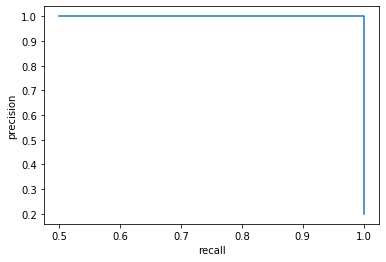

In [7]:
if __name__ == '__main__':
    check_ap()